In [15]:
# Imports
import torch
from torchvision.datasets import CIFAR10
import torchvision.models as models
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn 
import numpy as np 
import argparse
import torch
import matplotlib.pyplot as plt
import os
import pandas as pd

import Torch_Pruning.torch_pruning as tp

In [3]:
# Create VGG architecture with custom classifier layers
class VGG(torch.nn.Module):
    def __init__(self, vgg='vgg16_bn', data_set='CIFAR10', pretrained=False):
        super(VGG, self).__init__()
        self.features = models.__dict__[vgg](pretrained=pretrained).features
        
        classifier = []
        if 'CIFAR' in data_set:
            num_class = int(data_set.split("CIFAR")[1])
            
            classifier.append(torch.nn.Linear(512, 512))
            classifier.append(torch.nn.BatchNorm1d(512))
            classifier.append(torch.nn.Linear(512, num_class))
        else:
            raise RuntimeError("Not expected data flag !!!")

        self.classifier = torch.nn.Sequential(*classifier)
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [4]:
# Code to prune model based on L1 norm of filter weights
# Prunes 'amount' percentage of filters based on lowest L1 norm
def prune_model(model):
    model.cpu()
    DG = tp.DependencyGraph().build_dependency( model, torch.randn(1, 3, 32, 32) )
   
    def prune_conv(conv, amount=0.2):
        strategy = tp.strategy.L1Strategy()
        pruning_index = strategy(conv.weight, amount=amount)
        plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, pruning_index)
        plan.exec()
    
    # Define percentages by which filters in each layer will be pruned
    block_prune_probs = [0.6, 0.1, 0.15, 0.1, 0.1, 0.15, 0.15, 0.2, 0.8, 0.8, 0.8, 0.4, 0.4]
    conv_id = 0
    for m in model.features:
        if isinstance( m, torch.nn.Conv2d ):
            prune_conv( m, block_prune_probs[conv_id] )
            conv_id += 1
    return model

In [5]:
# Prepare dataloaders for CIFAR10
def get_dataloader():
    train_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=True, transform=transforms.Compose([
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]), download=True),batch_size=256, num_workers=2)
    test_loader = torch.utils.data.DataLoader(
        CIFAR10('./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
        ]),download=True),batch_size=256, num_workers=2)
    return train_loader, test_loader

In [6]:
# Evaluate accuracy of model on test_loader
def eval(model, test_loader):
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, (img, target) in enumerate(test_loader):
            img = img.to(device)
            out = model(img)
            pred = out.max(1)[1].detach().cpu().numpy()
            target = target.cpu().numpy()
            correct += (pred==target).sum()
            total += len(target)
    return correct / total

In [7]:
# Train model on train_loader for given epochs and evaluate on test_loader
def train_model(model, train_loader, test_loader, epochs, round_num):
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 70, 0.1)
    model.to(device)
    acc_s = []
    best_acc = -1
    for epoch in range(epochs):
        model.train()
        for i, (img, target) in enumerate(train_loader):
            img, target = img.to(device), target.to(device)
            optimizer.zero_grad()
            out = model(img)
            loss = F.cross_entropy(out, target)
            loss.backward()
            optimizer.step()
        model.eval()
        acc = eval(model, test_loader)
        acc_s.append(acc)
        
        # Save model if it is better than previous checkpoint
        if best_acc<acc:
            torch.save( model, 'vgg16-round%d.pth'%(round_num) )
            best_acc=acc
        scheduler.step()
    return best_acc, np.mean(acc_s)

In [8]:
# Download dataset and create train and test dataloaders
train_loader, test_loader = get_dataloader()

Files already downloaded and verified
Files already downloaded and verified


In [9]:
# Create baseline model
model = VGG('vgg16_bn', 'CIFAR10')

In [10]:
params = sum([np.prod(p.size()) for p in model.parameters()])
print("Number of Parameters: %.1fM"%(params/1e6))

Number of Parameters: 15.0M


In [11]:
model_dict = {
    'params': [],
    'summary': [],
    'best_acc': [],
    'mean_acc': [],
    'out_channels': [],
    'size': [],
    'macs_params': []
}

In [12]:
# Iteratively prune and finetune network 
for i in range(5):
    print(f'--- Round {i} ---')
    
    # Prune only after 1st step since 1st step is baseline model
    if i > 0:
        model = prune_model(model)
        
    # Compute metrics after pruning to evaluate performance
    params = sum([np.prod(p.size()) for p in model.parameters()])
    model_dict['params'].append(params/1e6)
    model_dict['summary'].append(model)
    
    # Train model for 100 epochs in 1st step to create baseline model, else 30 epochs to finetune it
    best_acc, mean_acc = train_model(model, train_loader, test_loader, 100 if i == 0 else 30, i)
    model_dict['best_acc'].append(best_acc)
    model_dict['mean_acc'].append(mean_acc)
    model_dict['macs_params'].append(tp.utils.count_macs_and_params(model.cpu(), (1,3,32,32)))
    
    size = os.path.getsize('vgg16-round{x}.pth'.format(x=i)) / (1024 * 1024)
    model_dict['size'].append(size)
    print("Number of Parameters: %.1f M"%(params/1e6))
    print(f"Model Size: {size:.3f} MB")
    
    # Store number of out_channels in each conv layer
    out_ch = []
    for layer in model.features:
        if isinstance(layer, torch.nn.Conv2d):
            out_ch.append(layer.weight.data.cpu().numpy().shape[0])
    model_dict['out_channels'].append(out_ch)

--- Round 0 ---
Number of Parameters: 15.0 M
Model Size: 57.263 MB
--- Round 1 ---
Number of Parameters: 4.0 M
Model Size: 15.290 MB
--- Round 2 ---
Number of Parameters: 2.1 M
Model Size: 7.918 MB
--- Round 3 ---
Number of Parameters: 1.3 M
Model Size: 5.139 MB
--- Round 4 ---
Number of Parameters: 0.9 M
Model Size: 3.602 MB


In [13]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(2, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(44, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(68, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(86, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(86, 170, kernel_

In [14]:
model_dict

{'params': [14.991946, 3.993109, 2.062093, 1.334274, 0.931655],
 'summary': [VGG(
    (features): Sequential(
      (0): Conv2d(3, 2, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(2, 44, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(44, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(44, 68, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(68, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(68, 86, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(86, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): M

In [ ]:
# Plot all evaluation metrics against baseline model with successive rounds of pruning

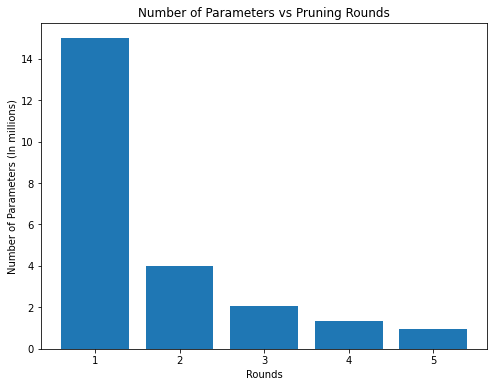

In [26]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 6), model_dict['params'])
plt.xlabel('Rounds')
plt.ylabel('Number of Parameters (In millions)')
plt.title('Number of Parameters vs Pruning Rounds')
plt.show()

In [47]:
for i, params in enumerate(model_dict['params']):
    print(f'Round {i+1}: Parameters = {params :.2f} M')

Round 1: Parameters = 14.99 M
Round 2: Parameters = 3.99 M
Round 3: Parameters = 2.06 M
Round 4: Parameters = 1.33 M
Round 5: Parameters = 0.93 M


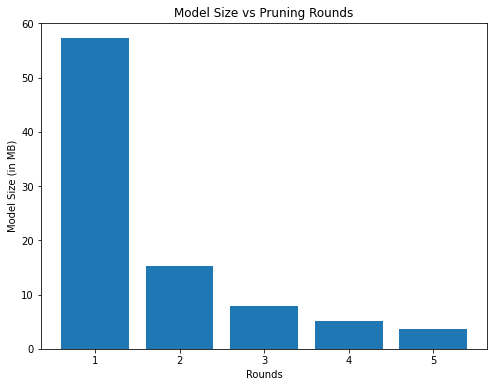

In [48]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 6), model_dict['size'])
plt.xlabel('Rounds')
plt.ylabel('Model Size (in MB)')
plt.title('Model Size vs Pruning Rounds')
plt.show()

In [51]:
for i, sz in enumerate(model_dict['size']):
    print(f'Round {i+1}: Model Size = {sz :.2f} MB')

Round 1: Model Size = 57.26 MB
Round 2: Model Size = 15.29 MB
Round 3: Model Size = 7.92 MB
Round 4: Model Size = 5.14 MB
Round 5: Model Size = 3.60 MB


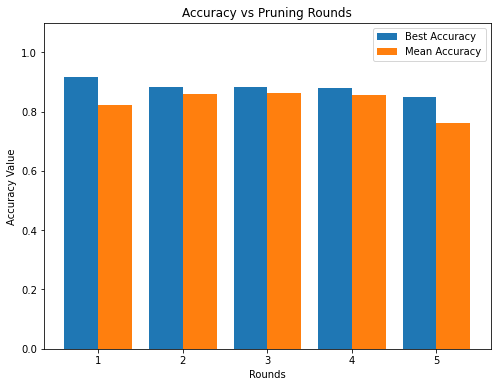

In [29]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 6) - 0.2, model_dict['best_acc'], 0.4, label='Best Accuracy')
plt.bar(np.arange(1, 6) + 0.2, model_dict['mean_acc'], 0.4, label='Mean Accuracy')
plt.ylim(0.0, 1.1)
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Accuracy Value')
plt.title('Accuracy vs Pruning Rounds')
plt.show()

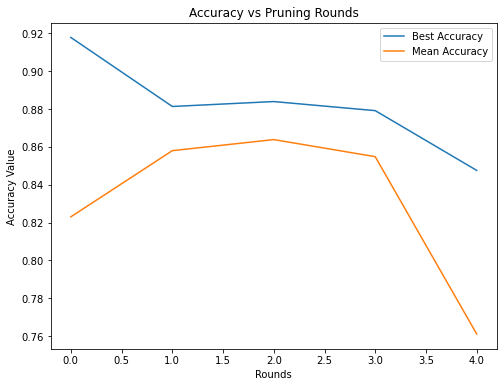

In [33]:
plt.figure(figsize=(8,6))
plt.plot(model_dict['best_acc'], label='Best Accuracy')
plt.plot(model_dict['mean_acc'], label='Mean Accuracy')
plt.legend()
plt.xlabel('Rounds')
plt.ylabel('Accuracy Value')
plt.title('Accuracy vs Pruning Rounds')
plt.show()

In [55]:
for i, acc in enumerate(model_dict['best_acc']):
    print(f'Round {i+1}: Best Test Accuracy = {acc :.2%}')

Round 1: Best Test Accuracy = 91.79%
Round 2: Best Test Accuracy = 88.14%
Round 3: Best Test Accuracy = 88.40%
Round 4: Best Test Accuracy = 87.92%
Round 5: Best Test Accuracy = 84.76%


In [56]:
for i, acc in enumerate(model_dict['mean_acc']):
    print(f'Round {i+1}: Mean Test Accuracy = {acc :.2%}')

Round 1: Mean Test Accuracy = 82.30%
Round 2: Mean Test Accuracy = 85.80%
Round 3: Mean Test Accuracy = 86.39%
Round 4: Mean Test Accuracy = 85.48%
Round 5: Mean Test Accuracy = 76.11%


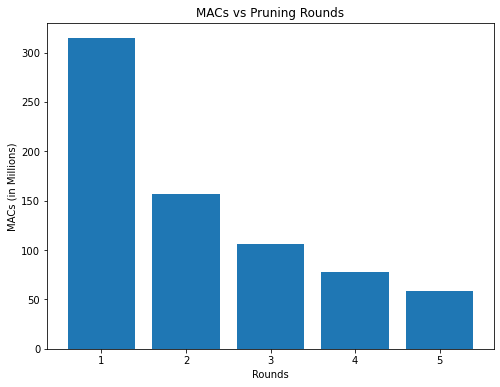

In [71]:
plt.figure(figsize=(8,6))
plt.bar(np.arange(1, 6), [a[0]/1e6 for a in model_dict['macs_params']])
plt.xlabel('Rounds')
plt.ylabel('MACs (in Millions)')
plt.title('MACs vs Pruning Rounds')
plt.show()

In [68]:
for i, tup in enumerate(model_dict['macs_params']):
    print(f'Round {i+1}: MACs = {tup[0]/1e6 :.2f}M, Parameters = {tup[1]/1e6 :.2f}M')

Round 1: MACs = 314.57M, Parameters = 14.99M
Round 2: MACs = 156.51M, Parameters = 3.99M
Round 3: MACs = 106.30M, Parameters = 2.06M
Round 4: MACs = 78.06M, Parameters = 1.33M
Round 5: MACs = 58.47M, Parameters = 0.93M


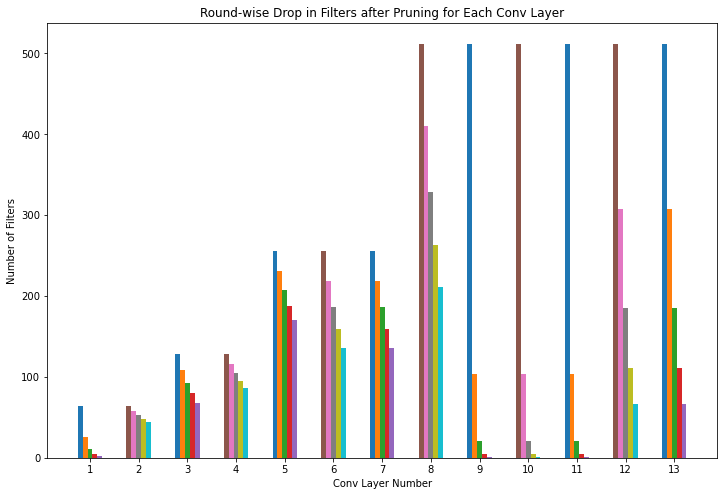

In [76]:
X = np.arange(1, 14)
plt.figure(figsize=(12, 8))

deltas = [-0.2, -0.1, 0, 0.1, 0.2]
for i in range(len(model_dict['out_channels'][0])):
    x = [a[i] for a in model_dict['out_channels']]
    for j in range(len(deltas)):
        plt.bar(X[i] + deltas[j], x[j], 0.1)

plt.xticks(X)
plt.xlabel('Conv Layer Number')
plt.ylabel('Number of Filters')
plt.title('Round-wise Drop in Filters after Pruning for Each Conv Layer')
plt.show()

In [126]:
cols = [f'Conv Layer {i+1}' for i in range(len(model_dict['out_channels'][0]))]
idxs = [f'Round {i+1}' for i in range(len(model_dict['out_channels']))]

In [136]:
pd.DataFrame(model_dict['out_channels'], columns = cols, index=idxs).transpose().head(20)

,Round 1,Round 2,Round 3,Round 4,Round 5
Conv Layer 1,64,26,11,5,2
Conv Layer 2,64,58,53,48,44
Conv Layer 3,128,109,93,80,68
Conv Layer 4,128,116,105,95,86
Conv Layer 5,256,231,208,188,170
Conv Layer 6,256,218,186,159,136
Conv Layer 7,256,218,186,159,136
Conv Layer 8,512,410,328,263,211
Conv Layer 9,512,103,21,5,1
Conv Layer 10,512,103,21,5,1


In [89]:
model_dict['out_channels']

[[64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512],
 [26, 58, 109, 116, 231, 218, 218, 410, 103, 103, 103, 308, 308],
 [11, 53, 93, 105, 208, 186, 186, 328, 21, 21, 21, 185, 185],
 [5, 48, 80, 95, 188, 159, 159, 263, 5, 5, 5, 111, 111],
 [2, 44, 68, 86, 170, 136, 136, 211, 1, 1, 1, 67, 67]]

In [112]:
for i in range(len(model_dict['out_channels'][0])):
    filters = [a[i] for a in model_dict['out_channels']]
    print(f'Number of Filters in Layer {i+1} in each round: ', end='')
    for x, j in enumerate(filters):
        print(str(j), end='')
        if x != len(model_dict['out_channels']) - 1:
            print(" => ", end='')
    print()

Number of Filters in Layer 1 in each round: 64 => 26 => 11 => 5 => 2
Number of Filters in Layer 2 in each round: 64 => 58 => 53 => 48 => 44
Number of Filters in Layer 3 in each round: 128 => 109 => 93 => 80 => 68
Number of Filters in Layer 4 in each round: 128 => 116 => 105 => 95 => 86
Number of Filters in Layer 5 in each round: 256 => 231 => 208 => 188 => 170
Number of Filters in Layer 6 in each round: 256 => 218 => 186 => 159 => 136
Number of Filters in Layer 7 in each round: 256 => 218 => 186 => 159 => 136
Number of Filters in Layer 8 in each round: 512 => 410 => 328 => 263 => 211
Number of Filters in Layer 9 in each round: 512 => 103 => 21 => 5 => 1
Number of Filters in Layer 10 in each round: 512 => 103 => 21 => 5 => 1
Number of Filters in Layer 11 in each round: 512 => 103 => 21 => 5 => 1
Number of Filters in Layer 12 in each round: 512 => 308 => 185 => 111 => 67
Number of Filters in Layer 13 in each round: 512 => 308 => 185 => 111 => 67
